<a href="https://colab.research.google.com/github/fastforwardlabs/snorkel-demo-colab/blob/master/snorkel_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a text classification model using noisy regular expressions

In this notebook we will walk through a simple text classification problem that trains a complaint classifier using data from [Consumer Financial Protection Bureau](https://www.consumerfinance.gov/data-research/consumer-complaints/), showing how to use Snorkel for weak supervision.

## Setup

Installing Snorkel and other required libraries

In [1]:
!pip3 install -r requirements.txt
!pip3 install git+https://github.com/nishamuktewar/snorkel
!pip3 install treedlib
!pip3 install numbskull

  Cloning https://github.com/nishamuktewar/snorkel to /tmp/pip-req-build-iwsmlw76
  Running command git clone -q https://github.com/nishamuktewar/snorkel /tmp/pip-req-build-iwsmlw76
  Stored in directory: /tmp/pip-ephem-wheel-cache-69shhwe9/wheels/1c/dc/7b/9cf55b0576fad8e74e4e4c004231d1fd2814b01915d5582ba2
Successfully built snorkel


In [0]:
%load_ext autoreload
%autoreload 2

Disabling warning messages

In [0]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Loading necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import os

from sklearn.model_selection import train_test_split
from collections import Counter
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass, Context, Candidate, StableLabel
from snorkel.contrib.models.text import RawText
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals
from snorkel.learning.tensorflow import TextRNN

## Download data, if it doesn't *exist*

In [0]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    !curl https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD > ./data/complaints.csv

## Preprocessing
Data load, filtering out irrelevant fields and rows. Each row in the final dataframe - complaints_df consists of a "complaint" field and an associated ground truth label = (1, -1). These ground truth labels are used to review the performance of the labeling process, afterall the whole idea is to do without any labeled data!

In [6]:
complaints = pd.read_csv(os.path.join(data_dir,'complaints.csv'))
complaints.info()
complaints.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323912 entries, 0 to 1323911
Data columns (total 18 columns):
Date received                   1323912 non-null object
Product                         1323912 non-null object
Sub-product                     1088746 non-null object
Issue                           1323912 non-null object
Sub-issue                       787656 non-null object
Consumer complaint narrative    393434 non-null object
Company public response         471011 non-null object
Company                         1323912 non-null object
State                           1303114 non-null object
ZIP code                        1202868 non-null object
Tags                            181223 non-null object
Consumer consent provided?      715997 non-null object
Submitted via                   1323912 non-null object
Date sent to company            1323912 non-null object
Company response to consumer    1323905 non-null object
Timely response?                1323912 non-null obj

(1323912, 18)

### Subset data to include products with narrative

In [0]:
products_w_narrative = complaints[complaints['Product'].notnull() & 
                                  complaints['Consumer complaint narrative'].notnull()]

In [8]:
print(products_w_narrative['Product'].unique())
print(products_w_narrative['Product'].value_counts())

['Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Credit card or prepaid card' 'Mortgage'
 'Payday loan, title loan, or personal loan' 'Student loan'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Checking or savings account' 'Credit card'
 'Credit reporting' 'Bank account or service' 'Consumer Loan'
 'Payday loan' 'Prepaid card' 'Money transfers' 'Other financial service'
 'Virtual currency']
Credit reporting, credit repair services, or other personal consumer reports    96687
Debt collection                                                                 88701
Mortgage                                                                        53810
Credit reporting                                                                31588
Credit card or prepaid card                                                     22425
Student loan                                                                    22253
Cred

### Selects two types of products - credit reporting and mortgage

In [0]:
# credit reporting only
credit_reporting = products_w_narrative[products_w_narrative['Product'] == 
                                        'Credit reporting, ' + 
                                        'credit repair services, or other personal consumer reports']
# mortgage only
mortgage = products_w_narrative[products_w_narrative['Product'] == 'Mortgage']

In [0]:
credit_narrative = credit_reporting['Consumer complaint narrative'].values
positive_labels = pd.Series(np.ones(credit_narrative.shape[0]))
positive_df = pd.DataFrame({'complaint': credit_narrative, 'label': 
                            positive_labels})

In [0]:
mortgage_narrative = mortgage['Consumer complaint narrative'].values
negative_labels = pd.Series(np.full(mortgage_narrative.shape[0], -1))
negative_df = pd.DataFrame({'complaint': mortgage_narrative, 'label': 
                            negative_labels})

### Combine into one dataframe, create labels 
(1 for credit reporting, -1 for mortgage)

In [12]:
complaints_df = pd.concat([positive_df, negative_df], ignore_index=True)
complaints_df.shape

(150497, 2)

In [13]:
complaints_df['label'].value_counts()

 1.0    96687
-1.0    53810
Name: label, dtype: int64

### Split data into train, dev, test

In [0]:
train, testval = train_test_split(complaints_df, test_size=0.2, random_state=123)
dev, test = train_test_split(testval, test_size=0.5, random_state=123)

## Create noisy labeling functions

Our assumption is that we don't have the ground truth labels for our data, but instead have these noisy and possibly conflicting labels based on regular expressions.

### Regular expressions that define words, phrases, actions for use in labeling functions

In [0]:
AGENCY_NAMES = r'\bexperian\b|\btransunion\b|\bequifax\b|\bfcra\b'   
DEBT_MENTIONS = r'\bcollector\b|\bdebt\b|\bcreditor\b'
ADDRESS_MENTIONS = r'\baddress\b'
DESCRIPTIONS = r'\binaccura|\bcompromise'
IDENTITY = r'\bidentity'
CREDIT_REPORT_MENTIONS = r'\bcredit (report|agency|reporting|bureau|agencies)'              
MORTGAGE_MENTIONS = r'\bloan\b|\bmortgage\|\bprepayment\b|\bprincipal\b|\binterest\b|\bescrow\b'
CHECKS = r'\bcheck'
TAXES = r'\btax'
LEASE = r'\blease'
HOUSE_MENTIONS = r'\bhouse\b|\bhome\bcondo\b'
MORTGAGE_HELP_ACTIONS = r'\bmitigat|\bmodifi\brefinanc'
MORTGAGE_COMPONENTS = r'\bequity\b|\bdownpayment\b|\bshortage\b'
POSITIVE_ACTIONS = r'\bremov|\bdispute\b' 
INQUIRY_ACTIONS  = r'\binquir\b|\berror\b'
NEGATIVE_ACTIONS = r'\bpredator|\bapprove|\bservic|\bappraise|\bforeclos'  
                                                                      
FRAUD = r'\bfraudulent (account|charges)'                                               
MONEYXFER = r'\bmoney transfer'                                                         
CREDIT_REPORTING = r'\b(identity has been compromise(|d)|data breaches|inquiries to bus\
inesses|mistakes appear in my report|reporting incorrectly|dispute(|d)|(t|T)ransunion|derog\
atory|experian|identity theft)'                                                             
CREDIT_REPAIR = r'\b(credit repair|hard inquiry|inquiries to businesses|mistakes appear\
 in my report|reporting incorrectly)'       

### Labeling functions that help provide weak supervision

In other words, instead of hand-labeling data to create a training set for our model, we write functions that look something like this:

In [0]:
def lf_agency_names(complaint):                                                                   
    if re.search(AGENCY_NAMES, str(complaint), re.IGNORECASE):                            
        return 1                                                                            
    else:                                                                                   
        return 0            

def lf_debt(complaint):                                                            
    if re.search(DEBT_MENTIONS, str(complaint), re.IGNORECASE):                           
        return 1                                                                            
    else:                                                                                   
        return 0      

def lf_address(complaint):                                                            
    if re.search(ADDRESS_MENTIONS, str(complaint), re.IGNORECASE):
        return 1                                                                            
    else:                                                                                   
        return 0     
    
def lf_credit_report(complaint):                                                           
    if re.search(CREDIT_REPORT_MENTIONS, str(complaint), re.IGNORECASE):                          
        return 1                                                                            
    else:                                                                                   
        return 0             
    
def lf_credit_actions(complaint):                                                           
    if re.search(POSITIVE_ACTIONS, str(complaint), re.IGNORECASE):                          
        return 1                                                                            
    else:                                                                                   
        return 0             
    
def lf_mortgage(complaint):                                                                 
    if re.search(MORTGAGE_MENTIONS, str(complaint), re.IGNORECASE):                            
        return -1                                                                           
    else:                                                                                   
        return 0        
    
def lf_inquiry(complaint):                                                                 
    if re.search(INQUIRY_ACTIONS, str(complaint), re.IGNORECASE):                            
        return 1                                                                           
    else:                                                                                   
        return 0        
    
def lf_house_mentions(complaint):                                                         
    if re.search(HOUSE_MENTIONS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0          
    
def lf_mortgage_help(complaint):                                                         
    if re.search(MORTGAGE_HELP_ACTIONS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0          
    
def lf_mortgage_components(complaint):                                                         
    if re.search(MORTGAGE_COMPONENTS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0          
    
def lf_fraud(complaint):                                                                    
    if (re.search(FRAUD, str(complaint), re.IGNORECASE)                                     
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                       
        return 1                                                                            
    elif (re.search(FRAUD, str(complaint), re.IGNORECASE)                                   
          and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                         
        return -1                                                                           
    else:                                                                                   
        return 0     
    
def lf_reporting(complaint):                                                                
    if (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)                          
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                       
        return 1                                                                            
    elif (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)                        
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                        
        return -1                                                                           
    else:                                                                                   
        return 0     

def lf_repair(complaint):                                                                   
    if (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE)                             
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)                         
        and not re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)                  
       ):                                                                                   
        return 1                                                                            
    elif ((re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE)                          
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE))                         
          or                                                                                
          (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE)                          
           and re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE))                  
         ):                                                                                 
        return -1                                                                           
    else:                                                                                   
        return 0  

def lf_credit_description(complaint):                                                                
    if (re.search(DESCRIPTIONS, str(complaint), re.IGNORECASE)                          
        and re.search(IDENTITY, str(complaint), re.IGNORECASE)):                       
        return 1                                                                                                                                             
    else:                                                                                   
        return 0           
    
def lf_description_not_mortgage(complaint):                                                                
    if (re.search(DESCRIPTIONS, str(complaint), re.IGNORECASE)                          
        and not re.search(MORTGAGE_MENTIONS, str(complaint), re.IGNORECASE)):                       
        return 1                                                                                                                                             
    else:                                                                                   
        return 0           
    
def lf_tax(complaint):                                                         
    if re.search(TAXES, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0    
    
def lf_check(complaint):                                                         
    if re.search(CHECKS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0    
    
def lf_lease(complaint):                                                         
    if re.search(LEASE, str(complaint), re.IGNORECASE):                          
        return 1                                                                          
    else:                                                                                   
        return 0    

## Generate Snorkel objects

### Candidates and Contexts

Candidate objects in Snorkel represent objects to be classified. In this case we are interested in classifying whether a complaint narrative is positive -that is credit related or not. All Candidate objects point to one or more Context objects representing the raw data that they are rooted in. In this case, our candidates will each point to a single Context object representing the raw text of the complaint.

In [17]:
session = SnorkelSession()

values = list(complaints_df.label.unique())
print(values)

# snorkel candidate, value if none defaults to binary (true, false)
Narrative = candidate_subclass('Narrative', ['narrative'], values=values)

# Make sure DB is cleared
session.query(Context).delete()
session.query(Candidate).delete()
session.query(StableLabel).delete()

[1.0, -1.0]


0

Once we have defined the context for each candidate, we split it into three sets :

- Training set (split=0): The narratives for which we have noisy, conflicting labels from our labeling functions; we will resolve these conflicts using the generative model and then use them as training data for the discriminative model (RNN in this case). The discriminative model is the standard goal in machine learning that learns to generalize beyond the training set. It takes as input the probabilistic labels output by the generative model. 

- Development/ validation set (split=1): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and it is used to help iterate the generative model training process. In later steps we also use it to test the discriminative model's (RNN in this case) performance on unseen data. 

- Test set (split=2): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use it to test the discriminative model's (RNN in this case) performance on unseen data   

We then commit it to the database.

In [18]:
train_index = train.index
train.index.str = np.asarray(str(x) for x in train.index)
train_complaints = train.values[:, 0]
train_labels = train.values[:, 1]

for element in zip(train_index, train_complaints, train_labels):
    split = 0
    raw_text = RawText(stable_id=element[0], name=element[0], 
                       text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)

dev_index = dev.index
dev.index.str = np.asarray(str(x) for x in dev.index)
dev_complaints = dev.values[:, 0]
dev_labels = dev.values[:, 1]

for element in zip(dev_index, dev_complaints, dev_labels):
    split = 1
    raw_text = RawText(stable_id=element[0], name=element[0], 
                       text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)

test_index = test.index
test.index.str = np.asarray(str(x) for x in test.index)
test_complaints = test.values[:, 0]
test_labels = test.values[:, 1]

for element in zip(test_index, test_complaints, test_labels):
    split = 2
    raw_text = RawText(stable_id=element[0], name=element[0], 
                       text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)

session.commit()

# number of datapoints
print("number of datapoints in candidate: ", session.query(Narrative).count())

# load ground truth labels
train_cand_labels = train_labels
dev_cand_labels = dev_labels
test_cand_labels = test_labels

number of datapoints in candidate:  150497


In [19]:
# test one labeling function
labeled = []
for c in session.query(Narrative).filter(Narrative.split == 1).all():
    if lf_tax(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

Number labeled: 1008


### Labels

Next, we assign labeling functions for each of the training candidates in a sparse matrix (which will also automatically be saved to the Snorkel database), with one row for each candidate and one column for each label

In [20]:
LFs = [lf_agency_names, lf_debt, lf_address, lf_credit_report, lf_credit_actions, 
       lf_inquiry, lf_mortgage, lf_house_mentions, lf_mortgage_components,
       lf_mortgage_help, lf_fraud, lf_reporting, lf_repair,
       lf_credit_description, lf_description_not_mortgage,
       lf_tax, lf_check, lf_lease]
# apply labeling functions
labeler = LabelAnnotator(lfs = LFs)
L_train = labeler.apply(split=0)

  0%|          | 25/120397 [00:00<08:06, 247.60it/s]

Clearing existing...
Running UDF...


100%|██████████| 120397/120397 [07:43<00:00, 260.02it/s]


In [21]:
# see what's going on
print(L_train.get_candidate(session, 0))
print(L_train.get_key(session, 0))
print(L_train.lf_stats(session))


Narrative(Raw Text I had homesite home owners ins. It was {$2000.00} a year. I had my mortgage company pay my taxes and insurance through an escrow account. I paid {$1500.00} as a fixed price. My taxes have NOT gone up. My PMI has NOT gone up. I changed my insurance company to liberty mutual. My new yearly price is {$1000.00}. When I notified Bogman Inc. of the change, my new monthly payment only went Down {$10.00}. I have called the company 4 times. First speaking to " XXXX '' whom did not help me, then to her manager " XXXX XXXX ''. Who is telling me they have only been paying {$1000.00} a year for my previous years insurance, which is a lie.)
LabelKey (lf_agency_names)
                              j  Coverage  Overlaps  Conflicts
lf_agency_names               0  0.280107  0.261875   0.061447
lf_debt                       1  0.145510  0.138251   0.057659
lf_address                    2  0.098840  0.093565   0.046571
lf_credit_report              3  0.439920  0.397809   0.141523
lf_c

## Training generative model


The problem with the above labeling functions is that they're noisy, conflicting and may even overlap on certain examples. The key technical idea of Snorkel's generative modeling approach is that we can automatically model and denoise them!

In [22]:
# Initialize Snorkel's generative model for
# learning the different worker accuracies.
gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(L_train, epochs=20, decay=0.95, step_size=0.1/L_train.shape[0], 
                reg_param=1e-6)

Inferred cardinality: 2


## Applying the generative model


### Probabilistic Label Statistics

We view the distribution of weak labels produced by our generative model. Note that the samples in the 0.5 bucket indicate the ones that have no LF coverage.

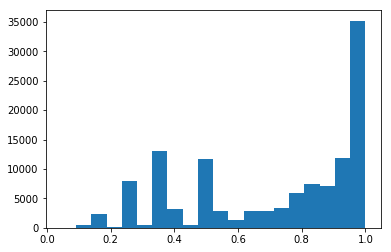

In [23]:
train_marginals = gen_model.marginals(L_train)
plt.hist(train_marginals, bins=20)
plt.show()

In [24]:
print("So we have ", (train_marginals == 0.5).sum(), 
      " samples where the LFs do not provide any coverage!")

So we have  10691  samples where the LFs do not provide any coverage!


### Compare learned accuracies vs empirical accuracies

#### Learned accuracies from our generative model

In [25]:
accuracy = gen_model.score(L_train, train_cand_labels)
print("precision: {:.5f}".format(accuracy[0]), 
      "recall: {:.5f}".format(accuracy[1]), 
      "F1: {:.5f}".format(accuracy[2]))

precision: 0.85814 recall: 0.90175 F1: 0.87941


#### Empirical accuracies of our labeling functions - majority vote

We observe that the majority vote approach does almost as well as the generative model for our use case! The labeling functions that we have defined are pretty simple, they essentially look at certain keywords. In a realistic scenario, the labeling sources may not just look at presence of some keywords but also knowledge bases, distant supervision, or even crowd-source them. 

In [26]:
# Collect the majority vote answer for each complaint
mv = []
for i in range(L_train.shape[0]):
    #indicates that there is no coverage for a particular datapoint
    if np.diff(L_train[i].indptr) != 0:   
        c = Counter([L_train[i,j] for j in L_train[i].nonzero()[1]])
        mv.append(c.most_common(1)[0][0])
    else:
        # assume that no label is equivalent to abstaining
        mv.append(0) 
mv = np.array(mv)

# Count the number correct by majority vote
n_correct = np.sum([1 for i in range(L_train.shape[0]) if mv[i] == 
                    train_cand_labels[i]])
print ("Accuracy:{}".format(n_correct / float(L_train.shape[0])))
print ("Number incorrect:{}".format(L_train.shape[0] - n_correct))

# Compute and return precision, recall
tp = (0.5 * (mv * train_cand_labels + 1))[mv == 1].sum()
pred_pos = mv[mv == 1].sum()
p = tp / float(pred_pos) if pred_pos > 0 else 0.0
pos = train_cand_labels[train_cand_labels == 1].sum()
r = tp / float(pos) if pos > 0 else 0.0

# Compute general F-beta score
beta=1
if p + r > 0:
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r))
else:
    f_beta = 0.0

print("precision: {:.5f}".format(p), 
      "recall: {:.5f}".format(r), 
      "F1: {:.5f}".format(f_beta))


Accuracy:0.8078357434155337
Number incorrect:23136
precision: 0.87558 recall: 0.89427 F1: 0.88482


#### Performance on dev set

We can also get a more detailed score (true positives, false positives, true negatives, false negatives) on the dev set and iterate on the generative training process if we need to

In [27]:
L_dev = labeler.apply(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_cand_labels)

Clearing existing...


  0%|          | 27/15050 [00:00<00:56, 266.53it/s]

Running UDF...


100%|██████████| 15050/15050 [00:58<00:00, 258.26it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.901
Neg. class accuracy: 0.728
Precision            0.855
Recall               0.901
F1                   0.877
----------------------------------------
TP: 8675 | FP: 1473 | TN: 3946 | FN: 956



Saving the predictions of the generative model on the train set back to the database for future use

In [28]:
save_marginals(session, L_train, train_marginals)

Saved 120397 marginals


## Training a *noise-aware* discriminative model

In this step we set up a noise-aware discriminative model in TensorFlow and see how close we come to the fully supervised version!

### First, load the candidates

In [0]:
train_cands = session.query(Narrative).filter(Narrative.split == 0).order_by(Narrative.id).all()
dev_cands   = session.query(Narrative).filter(Narrative.split == 1).order_by(Narrative.id).all()
test_cands  = session.query(Narrative).filter(Narrative.split == 2).order_by(Narrative.id).all()


### Train model using RNN

We decided to leverage Snorkel's built-in discriminative classifier and made some custom changes to work with our example. 

Note, how the number of training samples below are lower than what's present in the training set, it excludes samples where there was no LF coverage, that is it trains on train_marginals.shape[0] - (train_marginals == 0.5).sum() samples

In [31]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.2,
    'print_freq': 1,
    'seed': 123,
    'batch_size': 200,
    'max_sentence_length': 512,
    'vocab_size': 5000
}

lstm = TextRNN(seed=123, cardinality=Narrative.cardinality)
# Note: Y_train are the marginals but Y_dev are the gold/ ground truth labels
lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, 
           Y_dev=dev_cand_labels, **train_kwargs)

max sentence len in training data:  5729
but capped to:  512
And also curtailing warning(s) related to checking individual max sentence lengths in each narrative
currrent vocab size is:  170265
but capped to:  5000
[TextRNN] Training model
[TextRNN] n_train=109706  #epochs=10  batch size=200
[TextRNN] Epoch 0 (468.12s)	Average loss=0.442568	Dev F1=90.83
[TextRNN] Epoch 1 (964.29s)	Average loss=0.399934	Dev F1=91.14
[TextRNN] Epoch 2 (1470.67s)	Average loss=0.395937	Dev F1=90.66
[TextRNN] Epoch 3 (1968.91s)	Average loss=0.394322	Dev F1=90.20
[TextRNN] Epoch 4 (2464.33s)	Average loss=0.393556	Dev F1=90.14
[TextRNN] Epoch 5 (2956.59s)	Average loss=0.392860	Dev F1=89.59
[TextRNN] Epoch 6 (3448.02s)	Average loss=0.392751	Dev F1=90.42
[TextRNN] Epoch 7 (3938.71s)	Average loss=0.392483	Dev F1=90.96
[TextRNN] Epoch 8 (4431.30s)	Average loss=0.392119	Dev F1=90.41
[TextRNN] Model saved as <TextRNN>
[TextRNN] Epoch 9 (4925.70s)	Average loss=0.392195	Dev F1=90.76
[TextRNN] Model saved as <TextRNN>

### Accuracies on dev and test datasets

In [32]:
accuracy_dev = lstm.score(dev_cands, dev_cand_labels, batch_size=200)
print("precision: {:.5f}".format(accuracy_dev[0]), 
      "recall: {:.5f}".format(accuracy_dev[1]), 
      "F1: {:.5f}".format(accuracy_dev[2]))

precision: 0.85768 recall: 0.96366 F1: 0.90759


In [33]:
accuracy_test = lstm.score(test_cands, test_cand_labels, batch_size=200)
print("precision: {:.5f}".format(accuracy_test[0]), 
      "recall: {:.5f}".format(accuracy_test[1]), 
      "F1: {:.5f}".format(accuracy_test[2]))

precision: 0.86330 recall: 0.96787 F1: 0.91260
